# Модель роста опухоли с фармакокинетикой / фармакодинамикой

Этот ноутбук полностью самодостаточный:

* определяет простую ОДУ‑модель роста опухоли;
* добавляет одно‑компартментную фармакокинетику препарата;
* описывает фармакодинамический эффект (Emax‑модель гибели клеток);
* содержит 12 проверочных вызовов `simulate_tumor` для разных схем лечения.

Ничего менять не обязательно — можно сразу запускать все ячейки сверху вниз.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Чтобы графики были покрупнее
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True


## Определение модели

Переменные:

* `U(t)` — живые опухолевые клетки (объём / масса / условные единицы);
* `N(t)` — некротизированные клетки;
* `C(t)` — концентрация препарата в компартменте.

Упрощённая модель:

\begin{align}
\frac{dU}{dt} &= r U \Big(1 - \frac{U + N}{K}\Big) - k_{kill}(C) U \\
\frac{dN}{dt} &= k_{kill}(C) U - k_{clear} N \\
\frac{dC}{dt} &= -k_{el} C + I(t)
\end{align}

Эффект препарата (Emax‑модель):

\begin{align}
k_{kill}(C) = E_{max} \frac{C}{EC_{50} + C}
\end{align}

Ввод препарата задаётся в виде списка болюсных доз `doses = [(t, amount), ...]`.


In [2]:
class TumorPKPDParams:
    """Параметры модели опухоли и препарата."""
    def __init__(
        self,
        r: float = 0.01,         # скорость роста живых клеток
        K: float = 100.0,        # "ёмкость" окружения / максимальный объём опухоли
        k_clear: float = 0.001,  # клиренс некроза
        kel: float = 0.2,        # скорость элиминации препарата
        Emax: float = 0.5,       # максимальный эффект препарата
        EC50: float = 1.0        # концентрация для 50% эффекта
    ):
        self.r = r
        self.K = K
        self.k_clear = k_clear
        self.kel = kel
        self.Emax = Emax
        self.EC50 = EC50

    def kill_rate(self, C: float) -> float:
        """k_kill(C) по Emax‑модели."""
        return self.Emax * C / (self.EC50 + C + 1e-12)


def tumor_pkpd_step(U, N, C, params: TumorPKPDParams, dt: float, dose: float = 0.0):
    """Один шаг интегрирования методом Эйлера.

    U, N, C — состояния на начале шага,
    dt — шаг по времени,
    dose — болюсная доза, введённая в начале шага (мг, условные единицы).
    """
    # сначала учитываем болюс
    C = C + dose

    # вычисляем текущий kill rate
    k_kill = params.kill_rate(C)

    # dU/dt
    growth_term = params.r * U * (1.0 - (U + N) / params.K)
    kill_term = k_kill * U
    dU_dt = growth_term - kill_term

    # dN/dt
    dN_dt = kill_term - params.k_clear * N

    # dC/dt
    dC_dt = -params.kel * C

    # шаг Эйлера
    U_next = max(U + dU_dt * dt, 0.0)
    N_next = max(N + dN_dt * dt, 0.0)
    C_next = max(C + dC_dt * dt, 0.0)

    return U_next, N_next, C_next


## Функция `simulate_tumor`

Основная функция, которую мы будем вызывать во всех тестах.


In [3]:
def simulate_tumor(
    t_end: float = 365.0,
    dt: float = 0.1,
    U0: float = 1.0,
    N0: float = 0.0,
    C0: float = 0.0,
    params: TumorPKPDParams | None = None,
    doses: list | None = None,
):
    """Моделирование динамики опухоли и концентрации препарата.

    Параметры
    ---------
    t_end : float
        Конец моделирования (дни).
    dt : float
        Шаг интегрирования (дни).
    U0, N0, C0 : float
        Начальные значения U, N, C.
    params : TumorPKPDParams | None
        Параметры модели. Если None — используются значения по умолчанию.
    doses : list[(t, amount)] | None
        Список болюсных доз: момент времени t (дни) и amount (единицы концентрации).

    Возвращает
    ----------
    dict с полями:
        t, U, N, C, total (U+N)
    """
    if params is None:
        params = TumorPKPDParams()

    if doses is None:
        doses = []

    # Сортируем дозы на всякий случай
    doses = sorted(doses, key=lambda x: x[0])

    # предварительная подготовка доз: словарь {индекс шага: суммарная доза}
    dose_map = {}
    for t_dose, amount in doses:
        idx = int(round(t_dose / dt))
        dose_map[idx] = dose_map.get(idx, 0.0) + amount

    n_steps = int(t_end / dt) + 1
    t = np.linspace(0.0, t_end, n_steps)

    U = np.zeros(n_steps)
    N = np.zeros(n_steps)
    C = np.zeros(n_steps)

    U[0] = U0
    N[0] = N0
    C[0] = C0

    for i in range(1, n_steps):
        dose_now = dose_map.get(i, 0.0)
        U[i], N[i], C[i] = tumor_pkpd_step(U[i-1], N[i-1], C[i-1],
                                           params, dt, dose=dose_now)

    total = U + N

    return {
        "t": t,
        "U": U,
        "N": N,
        "C": C,
        "total": total,
        "params": params,
        "dt": dt,
        "doses": doses,
    }


## Вспомогательные функции для визуализации


In [4]:
def plot_tumor(result, title: str = ""):
    t = result["t"]
    U = result["U"]
    N = result["N"]
    total = result["total"]

    plt.figure()
    plt.plot(t, U, label="U (живые)")
    plt.plot(t, N, label="N (некроз)")
    plt.plot(t, total, label="Итого U+N", linestyle="--")
    plt.xlabel("Время, дни")
    plt.ylabel("Опухоль, усл. ед.")
    if title:
        plt.title(title)
    plt.legend()
    plt.show()


def plot_concentration(result, title: str = ""):
    t = result["t"]
    C = result["C"]

    plt.figure()
    plt.plot(t, C, label="C (конц. препарата)")
    plt.xlabel("Время, дни")
    plt.ylabel("C, усл. ед.")
    if title:
        plt.title(title)
    plt.legend()
    plt.show()


## 12 проверочных вызовов

Ниже — 12 готовых сценариев. Можно просто выполнить ячейку целиком,
чтобы убедиться, что всё работает.


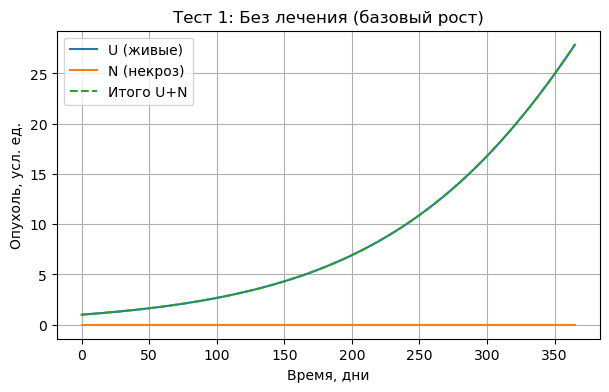

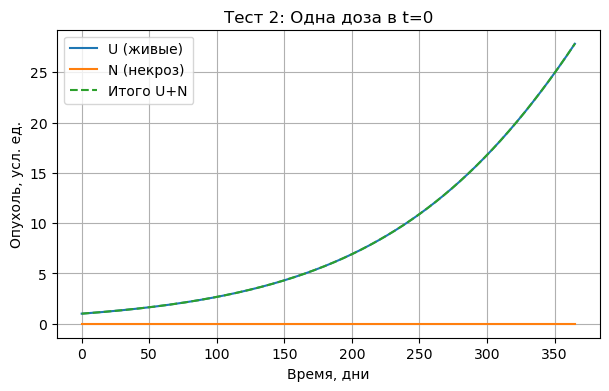

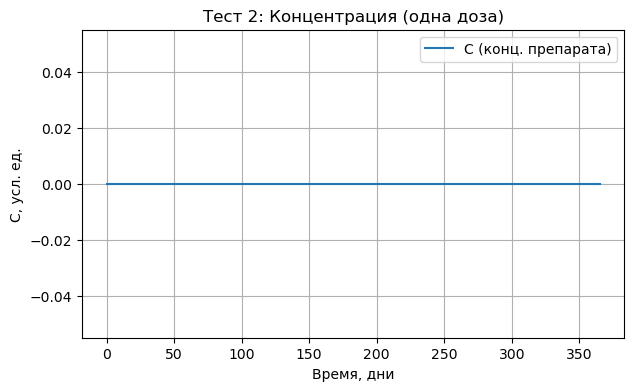

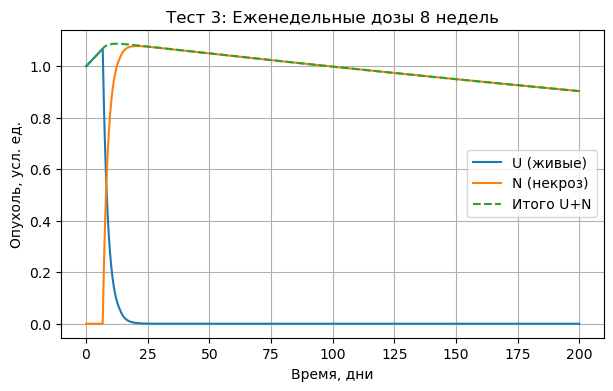

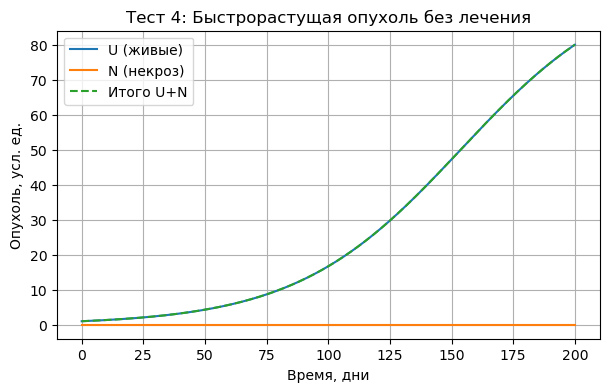

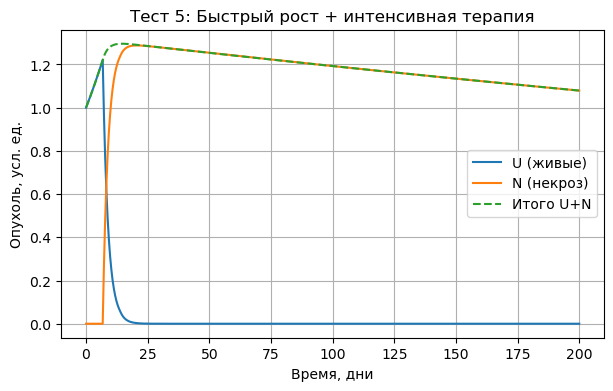

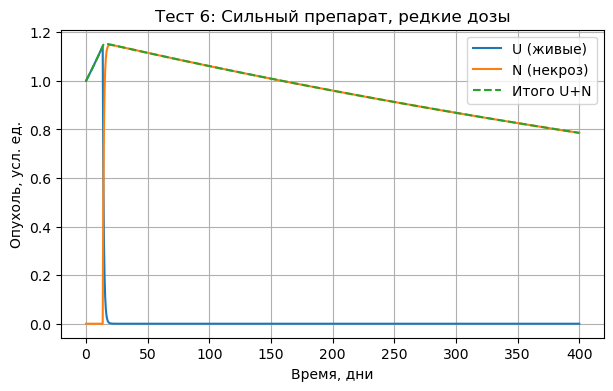

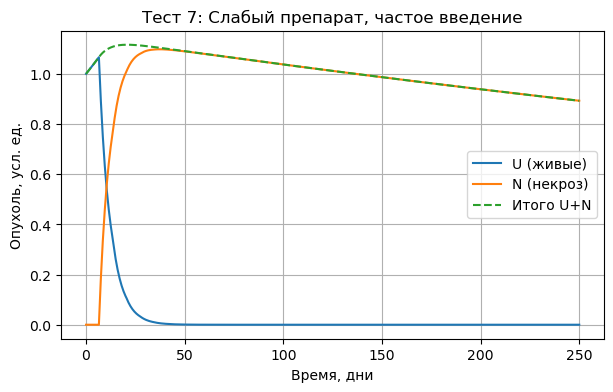

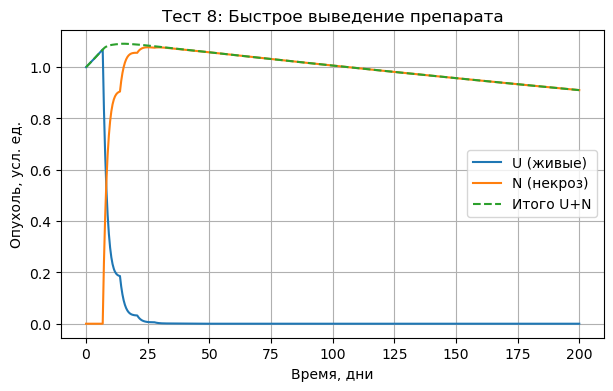

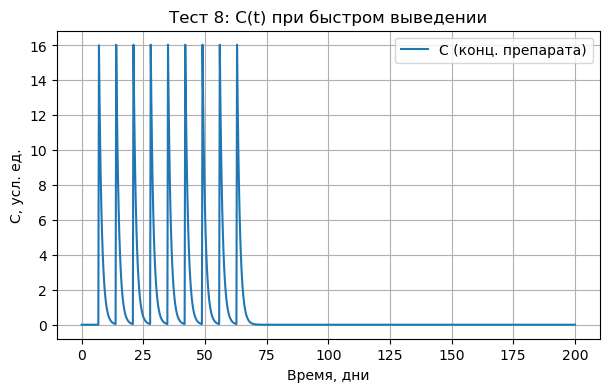

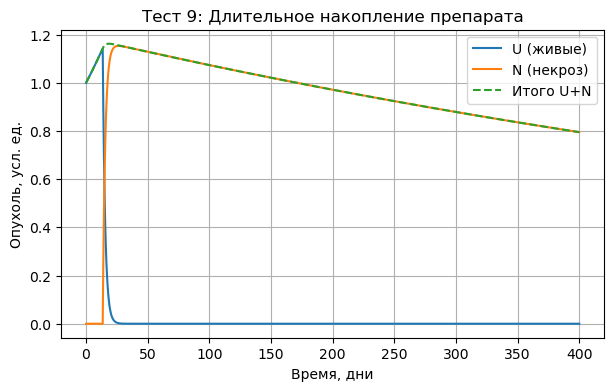

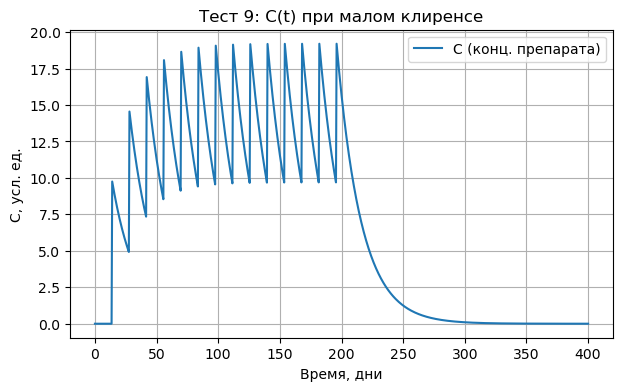

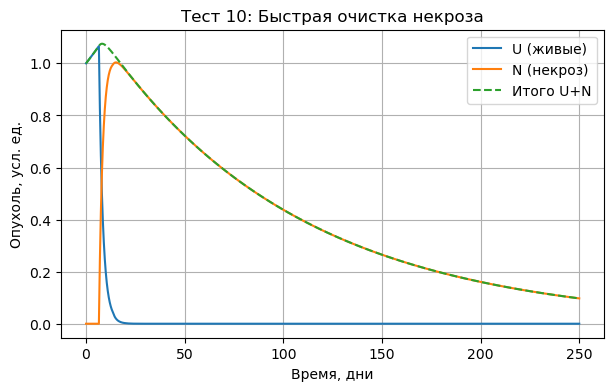

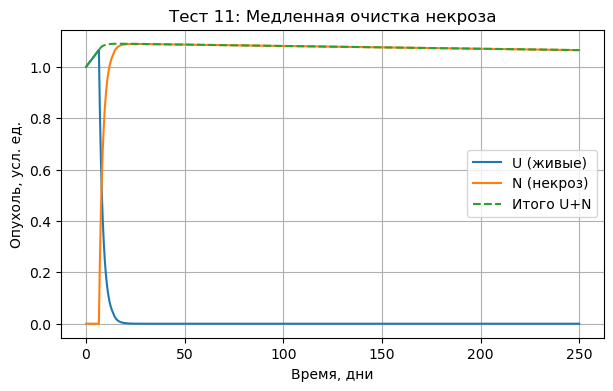

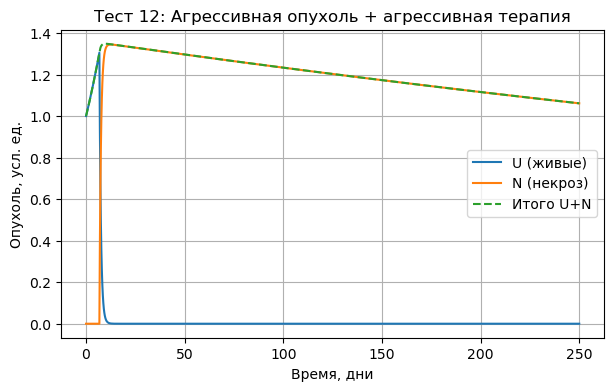

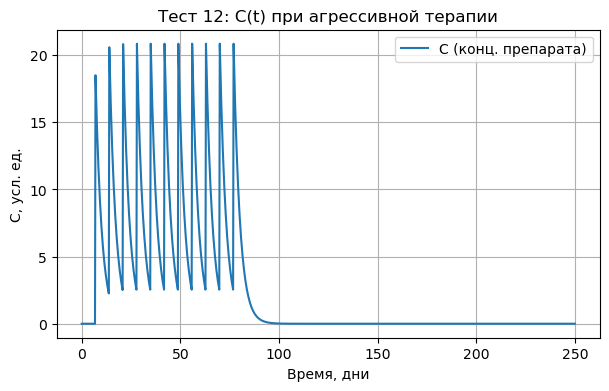

In [5]:
# 12 тестовых сценариев

# 1. Рост без лечения
params1 = TumorPKPDParams(r=0.01, K=100.0)
res1 = simulate_tumor(t_end=365, dt=0.5, params=params1, doses=None)
plot_tumor(res1, "Тест 1: Без лечения (базовый рост)")

# 2. Одна болюсная доза в начале
doses2 = [(0.0, 10.0)]
res2 = simulate_tumor(t_end=365, dt=0.5, params=params1, doses=doses2)
plot_tumor(res2, "Тест 2: Одна доза в t=0")
plot_concentration(res2, "Тест 2: Концентрация (одна доза)")

# 3. Еженедельные дозы 8 недель
doses3 = [(7.0 * i, 10.0) for i in range(8)]
res3 = simulate_tumor(t_end=200, dt=0.25, params=params1, doses=doses3)
plot_tumor(res3, "Тест 3: Еженедельные дозы 8 недель")

# 4. Более агрессивная опухоль (большой r)
params4 = TumorPKPDParams(r=0.03, K=100.0)
res4 = simulate_tumor(t_end=200, dt=0.25, params=params4, doses=None)
plot_tumor(res4, "Тест 4: Быстрорастущая опухоль без лечения")

# 5. Быстрорастущая опухоль + интенсивное лечение
doses5 = [(7.0 * i, 15.0) for i in range(10)]
res5 = simulate_tumor(t_end=200, dt=0.25, params=params4, doses=doses5)
plot_tumor(res5, "Тест 5: Быстрый рост + интенсивная терапия")

# 6. Высокий Emax (сильный препарат)
params6 = TumorPKPDParams(r=0.01, K=100.0, Emax=1.0, EC50=1.0)
doses6 = [(14.0 * i, 10.0) for i in range(10)]
res6 = simulate_tumor(t_end=400, dt=0.5, params=params6, doses=doses6)
plot_tumor(res6, "Тест 6: Сильный препарат, редкие дозы")

# 7. Слабый препарат (низкий Emax)
params7 = TumorPKPDParams(r=0.01, K=100.0, Emax=0.2, EC50=1.0)
doses7 = [(7.0 * i, 10.0) for i in range(12)]
res7 = simulate_tumor(t_end=250, dt=0.5, params=params7, doses=doses7)
plot_tumor(res7, "Тест 7: Слабый препарат, частое введение")

# 8. Большой клиренс препарата (быстрое выведение)
params8 = TumorPKPDParams(r=0.01, K=100.0, kel=0.8)
doses8 = [(7.0 * i, 20.0) for i in range(10)]
res8 = simulate_tumor(t_end=200, dt=0.25, params=params8, doses=doses8)
plot_tumor(res8, "Тест 8: Быстрое выведение препарата")
plot_concentration(res8, "Тест 8: C(t) при быстром выведении")

# 9. Малый клиренс препарата (длительное накопление)
params9 = TumorPKPDParams(r=0.01, K=100.0, kel=0.05)
doses9 = [(14.0 * i, 10.0) for i in range(15)]
res9 = simulate_tumor(t_end=400, dt=0.5, params=params9, doses=doses9)
plot_tumor(res9, "Тест 9: Длительное накопление препарата")
plot_concentration(res9, "Тест 9: C(t) при малом клиренсе")

# 10. Быстрая очистка некроза (большой k_clear)
params10 = TumorPKPDParams(r=0.01, K=100.0, k_clear=0.01)
doses10 = [(7.0 * i, 10.0) for i in range(12)]
res10 = simulate_tumor(t_end=250, dt=0.5, params=params10, doses=doses10)
plot_tumor(res10, "Тест 10: Быстрая очистка некроза")

# 11. Медленная очистка некроза (малый k_clear)
params11 = TumorPKPDParams(r=0.01, K=100.0, k_clear=0.0001)
doses11 = [(7.0 * i, 10.0) for i in range(12)]
res11 = simulate_tumor(t_end=250, dt=0.5, params=params11, doses=doses11)
plot_tumor(res11, "Тест 11: Медленная очистка некроза")

# 12. Комбинация: быстрорастущая опухоль, сильный препарат, высокие дозы
params12 = TumorPKPDParams(r=0.04, K=150.0, Emax=1.2, EC50=0.8, kel=0.3)
doses12 = [(7.0 * i, 20.0) for i in range(12)]
res12 = simulate_tumor(t_end=250, dt=0.25, params=params12, doses=doses12)
plot_tumor(res12, "Тест 12: Агрессивная опухоль + агрессивная терапия")
plot_concentration(res12, "Тест 12: C(t) при агрессивной терапии")
